# Correlation between attributable death and severe illnesses with outdoor PM2.5 air concentrations

The objective of this part is to find a correlation between the PM2.5 levels given by WHO in countries, and the death rate attributable to outdoor particle pollution. We are making this link to be able to link this to PM2.5 levels obtained by inferring from the industry facilities location and gas pollutants emissions. 

The data used to find those attributable death comes from WHO and is given by country by year.

It also correct the age to account for this death rate independently of the age of the population. This is important as the different countries used to perform this analysis have widely different age distributions within the population. Hence, this has a big impact on the death toll, as for instance young children and elder people are more likely to suffer from diseases due to air pollution.

In [54]:
import gdrive_refs as names
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import scipy as sc

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
%matplotlib inline

In [55]:
root = "./../data/"
datasets = dict()
for name in names.gdrive_dic:
    address = root+name[1]
    datasets[name[1]] = pd.read_csv(address, on_bad_lines='skip')

# Loading the datasets

In [3]:
# Link to the source:
# https://www.who.int/data/gho/data/indicators/indicator-details/GHO/ambient-air-pollution-attributable-death-rate-(per-100-000-population-age-standardized)
attributable_death = pd.read_csv('../data/data-who-attributable-death-rate-air-pollutants.csv', header=2, on_bad_lines='skip', delimiter=';', encoding='UTF-8')
display(attributable_death.head(5))

# Link to source:
# https://www.who.int/data/gho/data/themes/air-pollution/who-air-quality-database/2016 
who_air_pollutants = pd.read_csv('../data/who-air-pollutants-db.csv', header=2, on_bad_lines='skip', delimiter=';')
display(who_air_pollutants.head(5))


,Location,Dim2,Indicator,Period,Dim1,Tooltip,IndicatorCode,FactValueForMeasure,FactValueString,FactValueUoM,...,LegendLabelText,LegendColorForText,LegendColorMaxNumeric,LegendColorMinNumeric,BasemapURL,LabelMapURL,LabelMapLanguage,FactValueNumericLowPrefix,FactValueNumericHighPrefix,OLDLegendLabelText
0,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Both sexes,111.5 [100.4 – 123.8],AIR_42,111.50,111.5 [100.4 – 123.8],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Male,124.4 [112 – 137.5],AIR_42,124.40,124.4 [112 – 137.5],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Female,99.56 [89.43 – 110.6],AIR_42,99.56,99.56 [89.43 – 110.6],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,Lower respiratory infections,Ambient air pollution attributable death rate ...,2016,Both sexes,16.56 [12.83 – 20.35],AIR_42,16.56,16.56 [12.83 – 20.35],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,Lower respiratory infections,Ambient air pollution attributable death rate ...,2016,Male,17.59 [13.63 – 21.62],AIR_42,17.59,17.59 [13.63 – 21.62],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,ID WHO city,Region,iso3,Country,City/Town,"Annual mean, ug/m3",Year,Number and type of monitoring stations (PM10),note on converted PM10,"Annual mean, ug/m3.1",Year.1,Number and type of monitoring stations (PM2.5),note on converted PM2.5,Temporal coverage,for air quality
0,1.0,Emr LMI,AFG,Afghanistan,Kabul,260.0,2009.0,"1 station, 1 station: urban",measured data,86,2009.0,"1 station, 1 station: urban",measured data,PM10: <75%; PM2.5:<75%,"Magnusson et al., Broad Exposure Screening of ..."
1,2.0,Emr LMI,AFG,Afghanistan,Mazar-e Sharif,334.0,2009.0,"1 station, 1 station: urban outskirts",measured data,68,2009.0,"1 station, 1 station: urban outskirts",measured data,PM10: <75%; PM2.5:<75%,"Magnusson et al., Broad Exposure Screening of ..."
2,3.0,Eur LMI,ALB,Albania,TIRANA,32.0,2013.0,"1 station, traffic, urban",measured data,16,2013.0,"1 station, traffic, urban",measured data,PM10: >75%; PM2.5:>75%,"European Environment Agency, Air quality e-rep..."
3,4.0,Eur HI,AND,Andorra,Escaldes-Engordany,18.0,2014.0,"1 station, urban",measured data,11,2014.0,"1 station, urban",measured data,PM10: NA; PM2.5:NA,Qualitat de l'aire a Andorra
4,5.0,Amr HI,ARG,Argentina,Buenos Aires,26.0,2015.0,"3 stations, residencial commercial",measured data,14,2015.0,-,converted from PM10,PM10: >75%; PM2.5:NA,"Agencia de Proteccion Ambiental, Buenos Aires"


# Data Cleaning

In [4]:
# PLOT HEATMAP OF NAN
# Source: https://gist.github.com/NadimKawwa/98e42c26401db0dffde95fe4ddbea67e

def plot_nan_heatmap(df):
    #set figure size
    plt.figure(figsize=(10,10))

    #generate heatmap
    sns.heatmap(df.isnull(), cbar=False)

    #labels and titles
    plt.title(f"NaN heatmap")
    #plt.yticks(np.arange(0, df.shape[0], 500))
    plt.xlabel("Column Index/Feature Space")
    plt.ylabel("Row Index/Observations")

    plt.show()



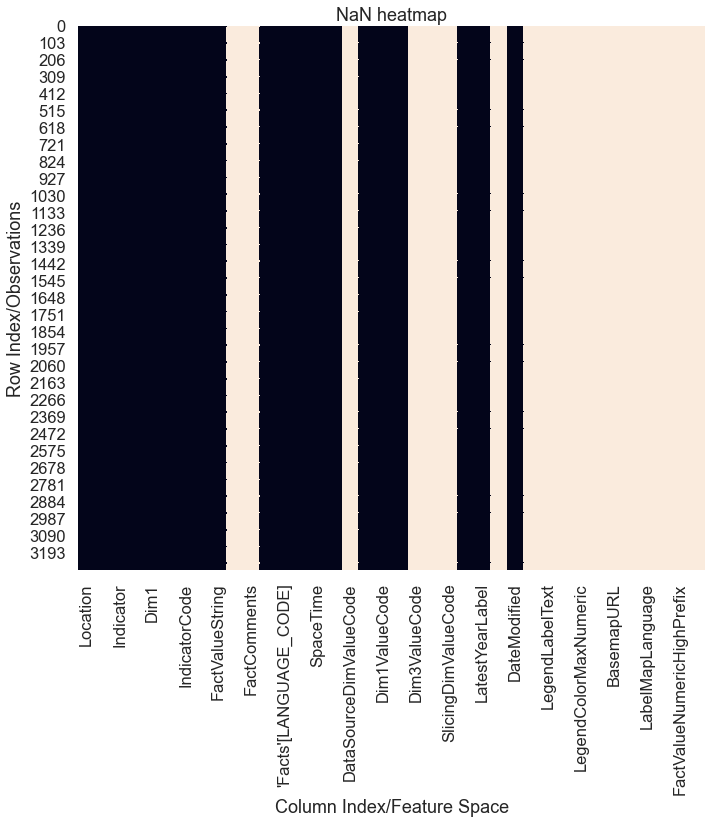

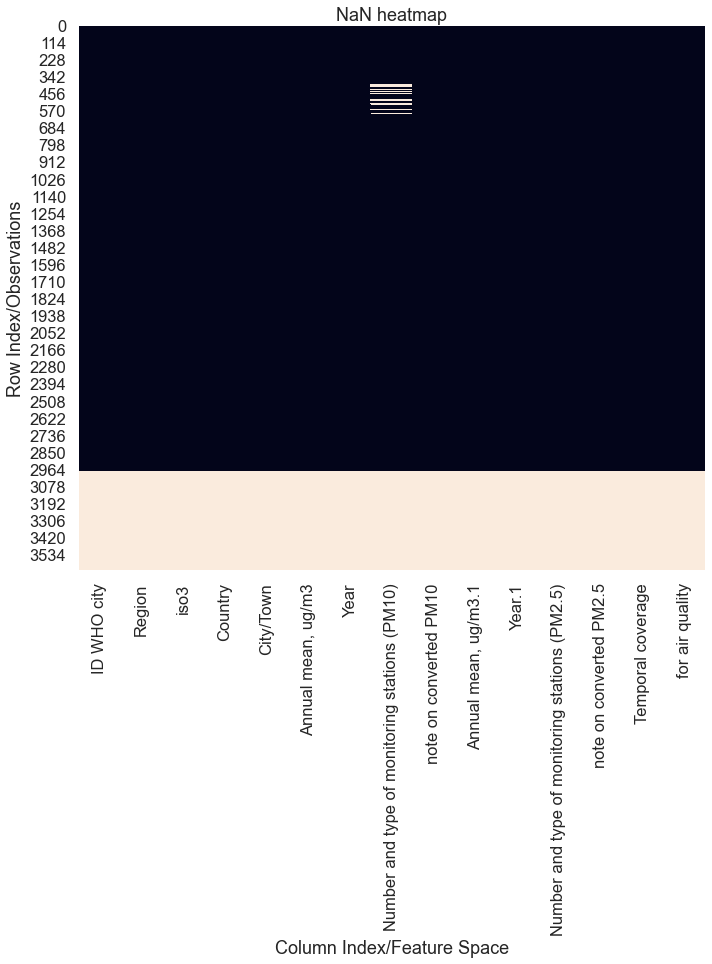

In [5]:
# DATA CLEANING ATTRIBUTABLE DEATH

plot_nan_heatmap(attributable_death)
plot_nan_heatmap(who_air_pollutants)


In [6]:
# Get all the nan columns
print('attributable death')
print(attributable_death.columns[attributable_death.isna().all()].tolist())

print('air pollutants')
print(who_air_pollutants.columns[who_air_pollutants.isna().all()].tolist())

attributable death
['FactValueUoM', 'FactComments', 'DataSourceDimValueCode', 'Dim3ValueCode', 'SlicingDimCode', 'SlicingDimValueCode', 'FactValueNumericPrefix', 'ClassBreakId', 'LegendLabelText', 'LegendColorForText', 'LegendColorMaxNumeric', 'LegendColorMinNumeric', 'BasemapURL', 'LabelMapURL', 'LabelMapLanguage', 'FactValueNumericLowPrefix', 'FactValueNumericHighPrefix', 'OLDLegendLabelText']
air pollutants
[]


In [7]:
# remove the nan columns

ad_null_cols = attributable_death.columns[attributable_death.isna().all()].tolist()
attributable_death = attributable_death.drop(ad_null_cols, axis=1)
print(attributable_death.columns[attributable_death.isna().all()].tolist())

[]


# Exploratory data analysis


In [8]:
# Print columns

print('attributable death')
print(attributable_death.columns.tolist())

print('\nair pollutants')
print(who_air_pollutants.columns.tolist())

attributable death
['Location', 'Dim2', 'Indicator', 'Period', 'Dim1', 'Tooltip', 'IndicatorCode', 'FactValueForMeasure', 'FactValueString', 'LanguageName', "'Facts'[LANGUAGE_CODE]", 'LanguageOrder', 'SpaceTime', 'TimeDimValueCode', 'SpatialDimValueCode', 'Dim1ValueCode', 'Dim2ValueCode', 'IsLatestYear', 'LatestYearLabel', 'DateModified']

air pollutants
['ID WHO city', 'Region', 'iso3', 'Country', 'City/Town', 'Annual mean, ug/m3', 'Year', 'Number and type of monitoring stations (PM10)', 'note on converted PM10', 'Annual mean, ug/m3.1', 'Year.1', 'Number and type of monitoring stations (PM2.5)', 'note on converted PM2.5', 'Temporal coverage', 'for air quality']


In [9]:
# A bit of EDA over the attributable deaths from WHO

print(attributable_death.describe())

print(attributable_death['Indicator'].unique())
# only 1 type of indicator= 'Ambient air pollution attributable death rate (per 100 000 population, age-standardized)'

print(attributable_death['Dim1ValueCode'].unique())
print(attributable_death['Dim1'].unique())
# Dim 1 is sex: both, male, female

print(attributable_death['Location'].unique())
# Location is the country
# LINK on this for the other table

print(attributable_death['LatestYearLabel'].unique())
# Only 1 value, 'latest'

print(attributable_death['IsLatestYear'].unique())
# Always true

print(attributable_death['DateModified'].unique())
# Modified only in end of 2018
# From the dataset source, data concerns the Year 2016


       Period  FactValueForMeasure  LanguageOrder  TimeDimValueCode
count  3294.0          3294.000000         3294.0            3294.0
mean   2016.0            16.525892            1.0            2016.0
std       0.0            22.016573            0.0               0.0
min    2016.0             0.069000            1.0            2016.0
25%    2016.0             2.570000            1.0            2016.0
50%    2016.0             7.800000            1.0            2016.0
75%    2016.0            20.517500            1.0            2016.0
max    2016.0           148.700000            1.0            2016.0
['Ambient air pollution attributable death rate (per 100 000 population, age-standardized)']
['BTSX' 'MLE' 'FMLE']
['Both sexes' 'Male' 'Female']
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia (Plurinational St

<AxesSubplot:xlabel='FactValueForMeasure', ylabel='Count'>

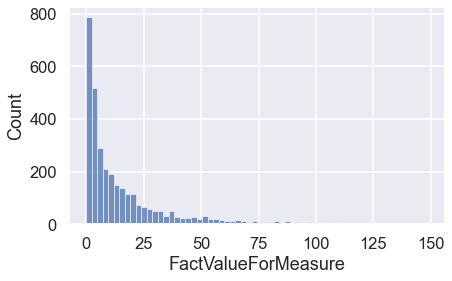

In [10]:
sns.histplot(attributable_death['FactValueForMeasure'])

The spread seems mostly on low death rates. Let's see below if the countries with higher levels of air pollutants correlates with this table.

In [11]:
columns_ap = ['ID WHO city', 'Region', 'iso3', 'Country', 'City/Town', 'Annual mean, ug/m3', 'Year', 'Number and type of monitoring stations (PM10)', 'note on converted PM10', 'Annual mean, ug/m3.1', 'Year.1', 'Number and type of monitoring stations (PM2.5)', 'note on converted PM2.5', 'Temporal coverage', 'for air quality']

print(who_air_pollutants['Temporal coverage'].unique())
# Type of coverage obtained on this year

print(who_air_pollutants['Year.1'].unique())
# No 2016 DATA present
# We can try to use air pollutants from a few years before and weight their impact in the regression

print(who_air_pollutants['Year'].unique())
# Seems to be a duplicata


['PM10: <75%; PM2.5:<75%' 'PM10: >75%; PM2.5:>75%' 'PM10: NA; PM2.5:NA'
 'PM10: >75%; PM2.5:NA' 'PM10: NA; PM2.5:>75%'
 'PM10: NA; PM2.5:<75 % but annually representative'
 'PM10: <75 % but annually representative; PM2.5:<75%'
 'PM10: <75 % but annually representative; PM2.5:<75 % but annually representative'
 'PM10: <75%; PM2.5:NA'
 'PM10: <75 % but annually representative; PM2.5:NA'
 'PM10: <75 % but annually representative; PM2.5:>75%'
 'PM10: <75%; PM2.5:>75%' 'PM10: NA; PM2.5:<75%'
 'PM10: >75%; PM2.5:<75 % but annually representative'
 'PM10: >75%; PM2.5: >75%'
 'PM10: <75%; PM2.5:<75 % but annually representative'
 'PM10: >75%; PM2.5:<75%'
 'PM10: <75 % but annually representative; PM2.5: :<75%' nan
 'PM10: <75 %, only day time monitoring but annually representative; PM2.5:<75 % but annually representative'
 'PM10: <75 %, only day time monitoring but annually representative; PM2.5:<75 % only day time monitoring  but annually representative'
 'PM10: NA; PM2.5:<75% but annually re

<AxesSubplot:xlabel='Annual mean, ug/m3', ylabel='Count'>

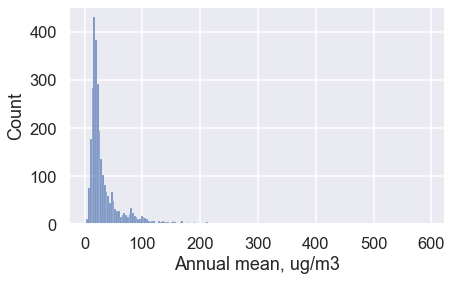

In [12]:
# for PM10
sns.histplot(who_air_pollutants['Annual mean, ug/m3'])

<AxesSubplot:xlabel='Annual mean, ug/m3.1', ylabel='Count'>

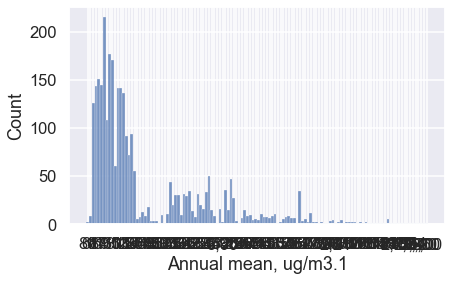

In [21]:
# for PM2.5
sns.histplot(who_air_pollutants['Annual mean, ug/m3.1'])

# Joining data

### Performing the join

(Per country)

Y-axis: FactValueForMeasure

X-axis: Air pollutants levels (try for PM2.5 and PM10)


### Temporal coverage to use

Link on 2016 data (year for the attributable death rate)

Use 2015 and few years before data for air pollutants, see if the correlation appears

*Note:* There is most likely a strong dependance between air pollutants emitted the years previously and attributable death rate on one year! This could be a path to explore later.


### Grannularity

The rows concerns specific countries. We will train our algorithm to match a country PM2.5 emission level and its attributable death rates.

(3628, 15)


<AxesSubplot:xlabel='Year', ylabel='Count'>

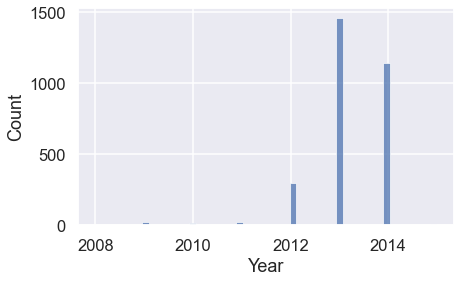

In [23]:

# LOCATION DATA
# Here there is location data by city
# Try aggregating all cities by mean in a country

# 
print(who_air_pollutants.shape)
sns.histplot(who_air_pollutants['Year'])
# not enough data for 2015 -> trying on 2012 and above

We will only take recent data, from 2012, 2013 and 2014.

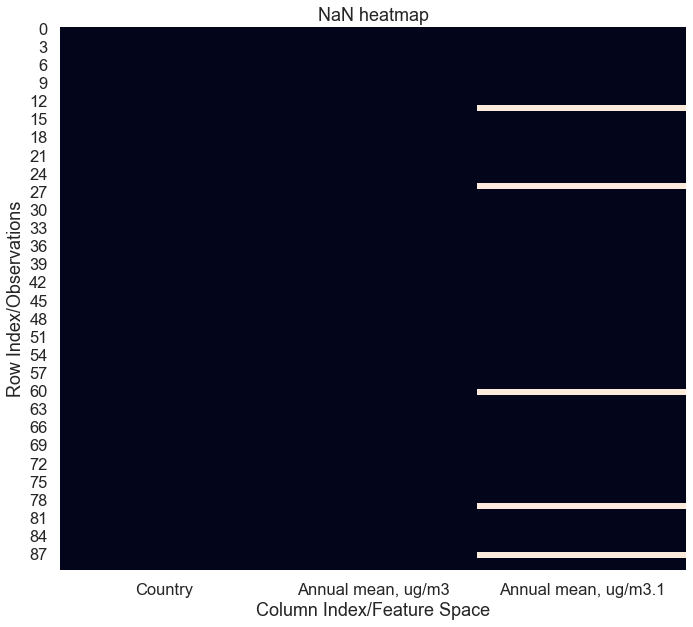

In [24]:
# Taking recent data
ap_by_country = who_air_pollutants[who_air_pollutants['Year'] >= 2012].loc[:,['Country', 'Annual mean, ug/m3', 'Annual mean, ug/m3.1']]
ap_by_country.shape

ap_by_country['Annual mean, ug/m3'].convert_dtypes(convert_integer=True)
ap_by_country['Annual mean, ug/m3.1'].convert_dtypes(convert_integer=True)

# trick from: https://stackoverflow.com/questions/46937399/pandas-groupby-and-agg-ignore-errors
# ignore the few weird lines coming up
def mean_agg_ignore_error(x):
    try:
        return np.mean(x)
    except:
        return np.nan

ap_by_country = ap_by_country.groupby('Country').aggregate({'Country': 'first', 'Annual mean, ug/m3': mean_agg_ignore_error, 'Annual mean, ug/m3.1': mean_agg_ignore_error})

# adding a simple incremental index
ap_by_country['index'] = np.arange(len(ap_by_country))
ap_by_country.set_index('index', inplace=True)

plot_nan_heatmap(ap_by_country)
# only a few lines still have nan values

In [25]:
# Work on attributable death table to perform the join

# We keep total of death counts, for both sexes
ad_by_country = attributable_death[attributable_death['Dim2'] == 'Total'][attributable_death['Dim1'] == 'Both sexes']

# We only keep the columns of interest
ad_by_country = ad_by_country.loc[:,['Location', 'FactValueForMeasure']].rename({'Location': 'Country'}, axis=1)
ad_by_country['Country'] = ad_by_country['Country'].convert_dtypes(convert_string=True)
ap_by_country['Country'] = ap_by_country['Country'].convert_dtypes(convert_string=True)

display(ad_by_country)
display(ap_by_country)

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,Country,FactValueForMeasure
0,Afghanistan,111.50
18,Albania,41.31
36,Algeria,43.31
54,Angola,55.92
72,Antigua and Barbuda,28.56
...,...,...
3204,Venezuela (Bolivarian Republic of),31.51
3222,Viet Nam,36.20
3240,Yemen,122.60
3258,Zambia,47.31


,Country,"Annual mean, ug/m3","Annual mean, ug/m3.1"
index,,,
0,Albania,32.000000,1.600000e+01
1,Andorra,18.000000,1.100000e+01
2,Argentina,26.000000,1.400000e+01
3,Australia,17.594595,2.102613e+37
4,Austria,21.450000,1.686886e+117
...,...,...,...
85,United Arab Emirates,135.800000,1.130525e+09
86,United Kingdom,17.880000,1.828242e+92
87,United States of America,15.341398,NaN


In [26]:
ap_ad_joined_tables = ap_by_country.set_index('Country').join(ad_by_country.set_index('Country'), how='outer', rsuffix='_r')

We will perform a bit of data cleaning on these joined tables

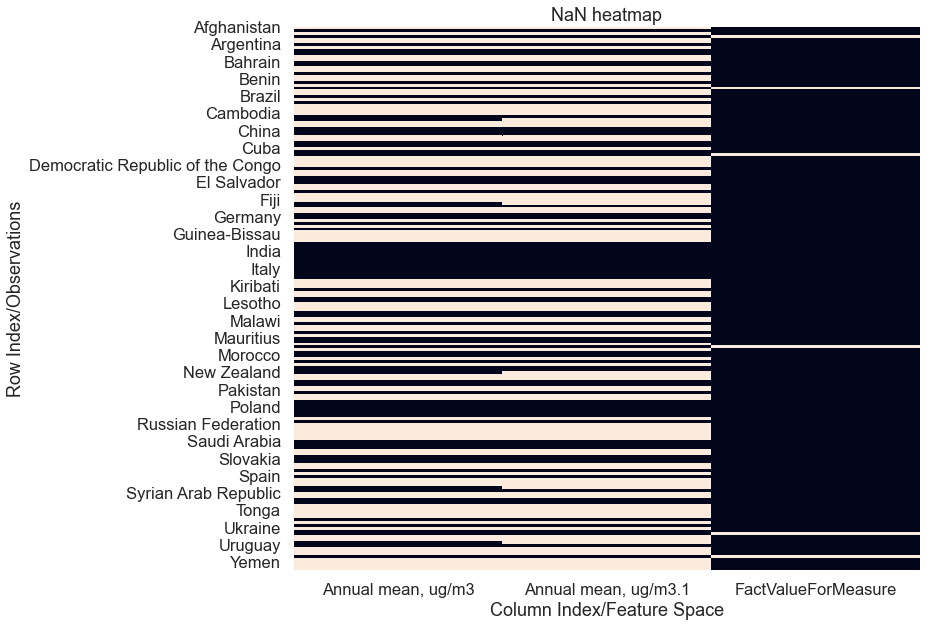

In [27]:
plot_nan_heatmap(ap_ad_joined_tables)

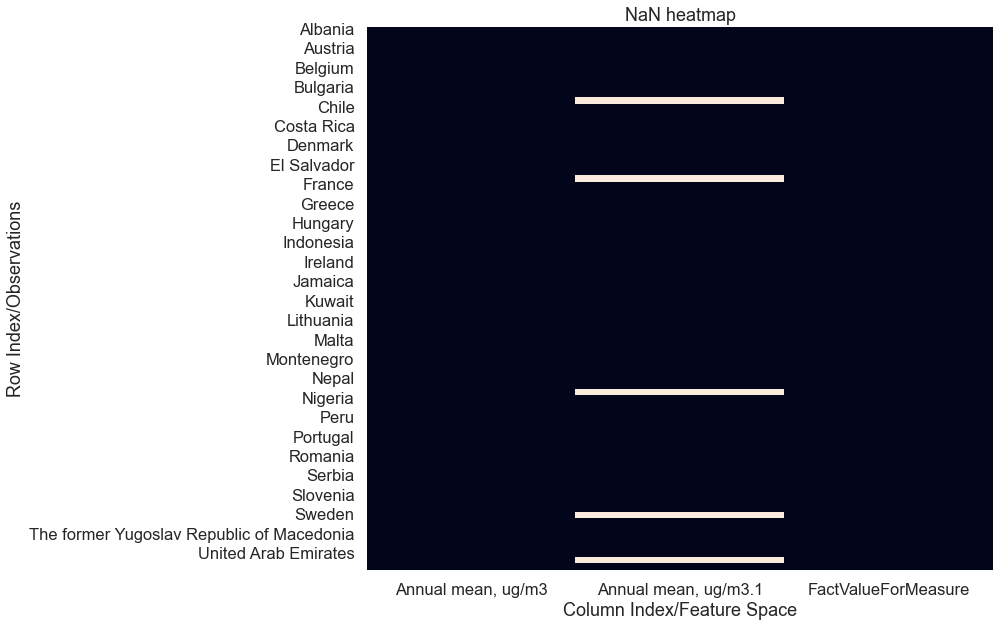

In [28]:
ap_ad_joined_tables = ap_ad_joined_tables[ap_ad_joined_tables['Annual mean, ug/m3'].notna()]
ap_ad_joined_tables = ap_ad_joined_tables[ap_ad_joined_tables['FactValueForMeasure'].notna()]

plot_nan_heatmap(ap_ad_joined_tables)

# Analysis of the correlations

## A few scatterplots 

### For PM10

Note: PM10 levels are logged into ```Annual mean, ug/m3.1``` column. PM2.5 are stored into ```Annual mean, ug/m3```.

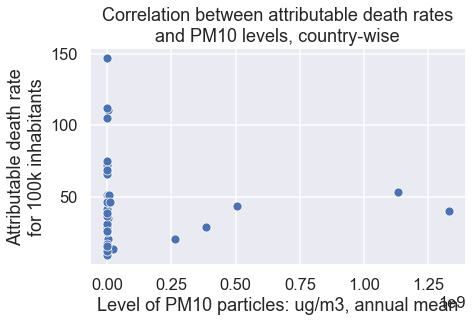

In [29]:
maximum = ap_ad_joined_tables['Annual mean, ug/m3.1'].max()
ap_ad_joined_tables31 = ap_ad_joined_tables[ap_ad_joined_tables['Annual mean, ug/m3.1'].notna()]
ap_ad_joined_tables31 = ap_ad_joined_tables[ap_ad_joined_tables['Annual mean, ug/m3.1'] < 10**10]
sns.scatterplot(x=ap_ad_joined_tables31['Annual mean, ug/m3.1'], y=ap_ad_joined_tables31['FactValueForMeasure'])

plt.title('Correlation between attributable death rates\nand PM10 levels, country-wise')
plt.xlabel('Level of PM10 particles: ug/m3, annual mean')
plt.ylabel('Attributable death rate\nfor 100k inhabitants')
plt.show()

As we can see here, for most of the countries, our data concerning PM10 is not sufficient. Indeed, for the wide majority of them, the level of PM10 is fairly low, and is probably due to an absence of monitoring. We cannot draw any relation from this. Let's see below how to use the PM2.5 levels to get a correlation between the attributable death rate and their outdoor concentration.

### For PM2.5 

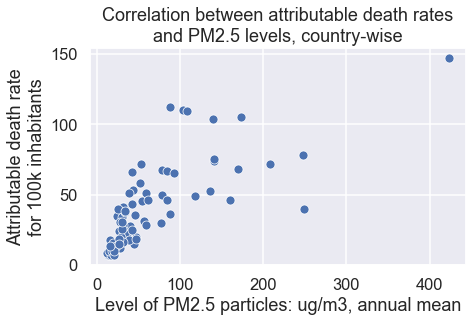

In [30]:
sns.scatterplot(x=ap_ad_joined_tables['Annual mean, ug/m3'], y=ap_ad_joined_tables['FactValueForMeasure'])
plt.title('Correlation between attributable death rates\nand PM2.5 levels, country-wise')
plt.xlabel('Level of PM2.5 particles: ug/m3, annual mean')
plt.ylabel('Attributable death rate\nfor 100k inhabitants')
plt.show()

There seems to be real correlation between the death rate to 100k inhabitants for diseases attributable to outdoor air pollution. Is is a bit skewed in the bottom-left part of the graph, and widens afterwards. We are going to use a log-log scale to explicit this correlation

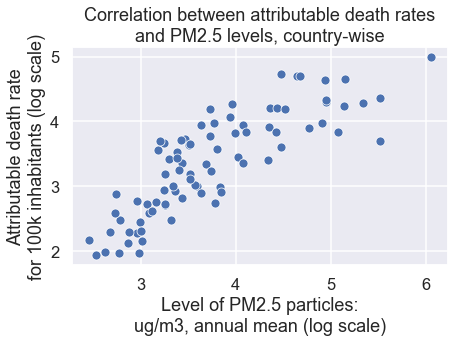

In [31]:
sns.scatterplot(x=np.log(ap_ad_joined_tables['Annual mean, ug/m3']), y=np.log(ap_ad_joined_tables['FactValueForMeasure']))
plt.title('Correlation between attributable death rates\nand PM2.5 levels, country-wise')
plt.xlabel('Level of PM2.5 particles:\nug/m3, annual mean (log scale)')
plt.ylabel('Attributable death rate\nfor 100k inhabitants (log scale)')
plt.show()

Here, we can clearly see a linear relation between both our variables. We will study the strength of this correlation below.

## Quality of the correlation

In [46]:

sc.stats.pearsonr(ap_ad_joined_tables['Annual mean, ug/m3'], ap_ad_joined_tables['FactValueForMeasure'])[0]
sc.stats.pearsonr(np.log(ap_ad_joined_tables['Annual mean, ug/m3']), np.log(ap_ad_joined_tables['FactValueForMeasure']))[0]

0.8325554653625008

The pearson coefficient is actually high (especially comparing to the brute meaning that we have done to be able to perform the join).
It's a bit better when accounting for log values, giving a
```r=0.8325554653625008```

Hence, There is indeed a correlation to be found between those variables.

Adding more variables in our prediction and applying feature engineering techniques could make this correlation better.


## Trying correlations for specific group of people and for specific illnesses

The groups of people available are:
- Women
- Men
- Both

The specific illnesses are:
- Lower respiratory infections
- Trachea, bronchus, lung cancers
- Ischaemic heart disease
- Stroke
- Chronic obstructive pulmonary disease
- Total

For the moment we have only used 'Total' death rates for both men and women.

In [77]:
air_pollution_illness = datasets['data-who-attributable-death-rate-air-pollutants.csv']
air_pollution_illness

,Location,Dim2,Indicator,Period,Dim1,Tooltip,IndicatorCode,FactValueForMeasure,FactValueString,FactValueUoM,...,LegendLabelText,LegendColorForText,LegendColorMaxNumeric,LegendColorMinNumeric,BasemapURL,LabelMapURL,LabelMapLanguage,FactValueNumericLowPrefix,FactValueNumericHighPrefix,OLDLegendLabelText
0,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Both sexes,111.5 [100.4 – 123.8],AIR_42,111.50,111.5 [100.4 – 123.8],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Male,124.4 [112 – 137.5],AIR_42,124.40,124.4 [112 – 137.5],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Female,99.56 [89.43 – 110.6],AIR_42,99.56,99.56 [89.43 – 110.6],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,Lower respiratory infections,Ambient air pollution attributable death rate ...,2016,Both sexes,16.56 [12.83 – 20.35],AIR_42,16.56,16.56 [12.83 – 20.35],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,Lower respiratory infections,Ambient air pollution attributable death rate ...,2016,Male,17.59 [13.63 – 21.62],AIR_42,17.59,17.59 [13.63 – 21.62],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289,Zimbabwe,Stroke,Ambient air pollution attributable death rate ...,2016,Male,6.63 [5.21 – 8.56],AIR_42,6.63,6.63 [5.21 – 8.56],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3290,Zimbabwe,Stroke,Ambient air pollution attributable death rate ...,2016,Female,8.37 [6.45 – 11.23],AIR_42,8.37,8.37 [6.45 – 11.23],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3291,Zimbabwe,Chronic obstructive pulmonary disease,Ambient air pollution attributable death rate ...,2016,Both sexes,5.47 [2.7 – 8.94],AIR_42,5.47,5.47 [2.7 – 8.94],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3292,Zimbabwe,Chronic obstructive pulmonary disease,Ambient air pollution attributable death rate ...,2016,Male,6.54 [3.22 – 10.68],AIR_42,6.54,6.54 [3.22 – 10.68],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='FactValueForMeasure', ylabel='Dim2'>

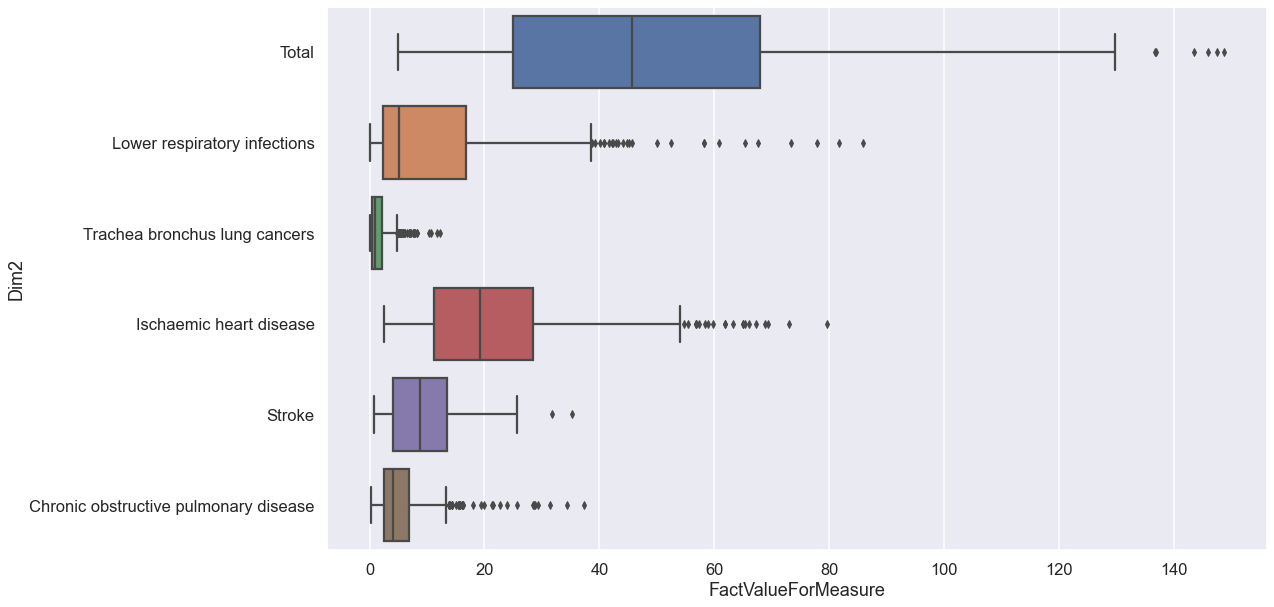

In [84]:
plt.figure(figsize=(15,10))
sns.boxplot(data = air_pollution_illness,x='FactValueForMeasure',y='Dim2')

,Location,Dim2,Indicator,Period,Dim1,Tooltip,IndicatorCode,FactValueForMeasure,FactValueString,FactValueUoM,...,LegendColorForText,LegendColorMaxNumeric,LegendColorMinNumeric,BasemapURL,LabelMapURL,LabelMapLanguage,FactValueNumericLowPrefix,FactValueNumericHighPrefix,OLDLegendLabelText,Prop
0,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Both sexes,111.5 [100.4 – 123.8],AIR_42,111.50,111.5 [100.4 – 123.8],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332379
1,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Male,124.4 [112 – 137.5],AIR_42,124.40,124.4 [112 – 137.5],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.370834
2,Afghanistan,Total,Ambient air pollution attributable death rate ...,2016,Female,99.56 [89.43 – 110.6],AIR_42,99.56,99.56 [89.43 – 110.6],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.296787
3,Afghanistan,Lower respiratory infections,Ambient air pollution attributable death rate ...,2016,Both sexes,16.56 [12.83 – 20.35],AIR_42,16.56,16.56 [12.83 – 20.35],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331532
4,Afghanistan,Lower respiratory infections,Ambient air pollution attributable death rate ...,2016,Male,17.59 [13.63 – 21.62],AIR_42,17.59,17.59 [13.63 – 21.62],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3289,Zimbabwe,Stroke,Ambient air pollution attributable death rate ...,2016,Male,6.63 [5.21 – 8.56],AIR_42,6.63,6.63 [5.21 – 8.56],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292715
3290,Zimbabwe,Stroke,Ambient air pollution attributable death rate ...,2016,Female,8.37 [6.45 – 11.23],AIR_42,8.37,8.37 [6.45 – 11.23],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369536
3291,Zimbabwe,Chronic obstructive pulmonary disease,Ambient air pollution attributable death rate ...,2016,Both sexes,5.47 [2.7 – 8.94],AIR_42,5.47,5.47 [2.7 – 8.94],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.326958
3292,Zimbabwe,Chronic obstructive pulmonary disease,Ambient air pollution attributable death rate ...,2016,Male,6.54 [3.22 – 10.68],AIR_42,6.54,6.54 [3.22 – 10.68],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.390915


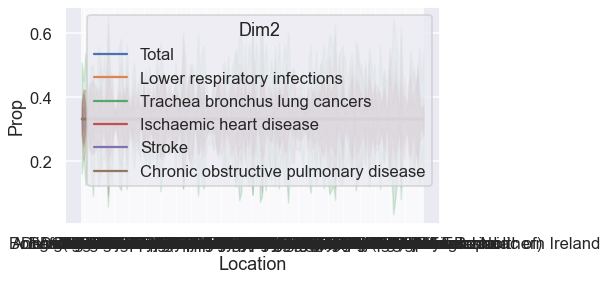

In [87]:
air_pollution_illness['Prop'] = air_pollution_illness['FactValueForMeasure']/air_pollution_illness.groupby(by=['Location','Dim2'])['FactValueForMeasure'].transform('sum')

sns.lineplot(data = air_pollution_illness, x='Location', y='Prop',hue='Dim2')

air_pollution_illness

# Inferencing the number of diseases related 

Since we found a relatively good linear correlation between $PM2.5$ and the attributable death rate, we would like to make some predictions on the number of attributable death within more recent years (2020 or 2021 for example), as well as the illnesses attributed to $PM2.5$. We begin by creating a linear model between the log of level PM2.5 and the log scaled attributable death rate for 100k inhabitants.

In [33]:
cleaned_table = ap_ad_joined_tables.reset_index().rename(columns={'Annual mean, ug/m3':'PM2.5 ug/m3','Annual mean, ug/m3.1':'PM10 ug/m3'}).fillna(0)
cleaned_table

,Country,PM2.5 ug/m3,PM10 ug/m3,FactValueForMeasure
0,Albania,32.000000,1.600000e+01,41.31
1,Argentina,26.000000,1.400000e+01,24.34
2,Australia,17.594595,2.102613e+37,8.39
3,Austria,21.450000,1.686886e+117,15.32
4,Bahrain,249.400000,1.328329e+09,40.14
...,...,...,...,...
79,Turkey,61.135802,3.511856e+158,46.57
80,Uganda,170.000000,1.040000e+02,68.67
81,United Arab Emirates,135.800000,1.130525e+09,53.05
82,United States of America,15.341398,0.000000e+00,13.31


In [34]:
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split

model = lm.LinearRegression()
X, y = np.log(cleaned_table.iloc[:,1].to_numpy().reshape(-1,1)),np.log(cleaned_table.iloc[:,3].to_numpy())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
regression = model.fit(X,y)

print("Accuracy of training:\t",model.score(X_train,y_train))
print("Accuracy of testing:\t",model.score(X_test,y_test))

Accuracy of training:	 0.7413118309239839
Accuracy of testing:	 0.5924732740716042


[1.31402053e+00 2.33254561e-08]
[1.31402058 1.31402058 1.31402057 1.31402057 1.31402059 1.31402059
 1.31402057 1.31402058 1.31402058 1.31402058 1.31402058 1.31402057
 1.31402058 1.31402058 1.31402058 1.31402058 1.31402058 1.31402058
 1.31402057 1.31402058 1.31402059 1.31402058 1.31402057 1.31402057
 1.31402057 1.31402058 1.31402057 1.31402058 1.31402058 1.31402058
 1.31402058 1.31402057 1.31402058 1.31402058 1.31402058 1.31402059
 1.31402057 1.31402058 1.31402058 1.31402058 1.31402058 1.31402058
 1.31402059 1.31402058 1.31402058 1.31402058 1.31402057 1.31402058
 1.31402058 1.31402058 1.31402058 1.31402058 1.31402058 1.31402058
 1.31402058 1.31402057 1.31402057 1.31402059 1.31402057 1.31402058
 1.31402058 1.31402058 1.31402058 1.31402057 1.31402059 1.31402058
 1.31402058 1.31402059 1.31402059 1.31402058 1.31402058 1.31402058
 1.31402058 1.31402058 1.31402057 1.31402057 1.31402057 1.31402058
 1.31402058 1.31402058 1.31402059 1.31402059 1.31402057 1.31402058]


<AxesSubplot:xlabel='Annual mean, ug/m3', ylabel='FactValueForMeasure'>

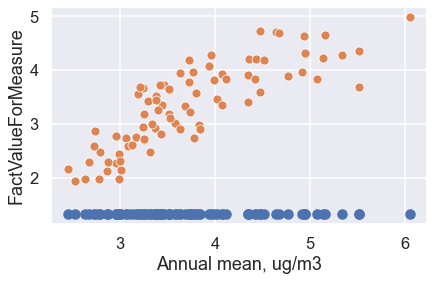

In [36]:
import scipy as sc

def f(x,a,b):
    return a+b*np.sqrt(x)

popt, pcov = sc.optimize.curve_fit(f,np.log(X.T[0]),np.log(y.T[0]))

print(popt)
print(f(X.T[0], popt[0],popt[1]))

plt.scatter(X.T[0], f(X.T[0], popt[0],popt[1]))
sns.scatterplot(x=np.log(ap_ad_joined_tables['Annual mean, ug/m3']), y=np.log(ap_ad_joined_tables['FactValueForMeasure']))